In [2]:

import pandas as pd
from experiments.musique.inference_only import macro_averaging
from knowledge_propagation.utils import io, vars, extractor
import os
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
from scipy.stats import describe
from thefuzz import fuzz


from knowledge_propagation.modules.evaluators import (
    ExactMatchEvaluator,
    RougeEvaluator,
    OpenAIEvaluator,
)
from scipy.special import softmax, log_softmax
from scipy.stats import entropy
from transformers import AutoTokenizer
from collections import defaultdict

tokenizer = AutoTokenizer.from_pretrained(
    f"{os.environ['SHARE_RES_DIR']}/models/llama3/hf/Llama-3.2-1B", add_eos_token=True, use_fast=False
)

os.getcwd()

/home/zliu/miniconda3/envs/cpt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'/data/users/zliu/mend/notebooks'

# analyze model's prediciton on years that don't need a carrier after +1

In [226]:
all_cpt_analysis_results = [io.load_json(f) for f in glob("/data/users/zliu/mend/debug_exp_output/Llama-3.2-1B-common-date-year-after-eos-sft_clm-baseline_lr=1e-05_epoch=4.0/individual_results_analysis/*.json")]
all_cpt_analysis_results = sorted(all_cpt_analysis_results, key=lambda x: int(x["id"]))

filtered_cpt_analysis_results = [x for x in all_cpt_analysis_results if not x["answer"].endswith("0")]
carrier_cpt_analysis_results = [x for x in all_cpt_analysis_results if x["answer"].endswith("0")]
len(filtered_cpt_analysis_results)

88

In [227]:
all_base_analysis_results = io.load_jsonlines("../debug_exp_output/llama3.2-1B-common-date-year-after-eos-sft/bio_syn_analysis/mend_eval_loss=sft_input=question_n=100_prompt=no_wo-icl_edit-model-infos.jsonl")

filtered_base_analysis_results = [x for x in all_base_analysis_results if not x["answer"].endswith("0")]
carrier_base_analysis_results = [x for x in all_base_analysis_results if x["answer"].endswith("0")]
len(filtered_base_analysis_results)

88

In [3]:
all_mend_1k_analysis_results = io.load_jsonlines("/data/users/zliu/mend/debug_exp_output/common-date-year-after_1K/bio_syn_analysis/mend_eval_loss=clm_input=question_n=100_prompt=no_wo-icl_edit-model-infos.jsonl")

assert all(d["answer_labels"][0] == 220 for d in all_mend_1k_analysis_results)
assert all(d["answer_labels"][-1] == 128001 for d in all_mend_1k_analysis_results)
assert all([len(x["answer_labels"][1:-1]) == 2 for x in all_mend_1k_analysis_results])

filtered_mend_1k_analysis_results = [x for x in all_mend_1k_analysis_results if not x["answer"].endswith("0")]
carrier_mend_1k_analysis_results = [x for x in all_mend_1k_analysis_results if x["answer"].endswith("0")]

In [231]:
len(filtered_mend_1k_analysis_results)

88

In [233]:
assert len(filtered_base_analysis_results) == len(filtered_mend_1k_analysis_results) == len(filtered_cpt_analysis_results)
assert len(carrier_base_analysis_results) == len(carrier_mend_1k_analysis_results) == len(carrier_mend_1k_analysis_results)

### Comparing Base vs CPT

In [217]:
df_content = []

a = defaultdict(list)

for model_name, analysis_results in [
    ("base", filtered_base_analysis_results),
    ("cpt", filtered_cpt_analysis_results),
    ("mend_1k", filtered_mend_1k_analysis_results)
]:
    for analysis_result in analysis_results:
        answer_labels = np.array(analysis_result["answer_labels"])
        answer_logits = np.array(analysis_result["answer_logits"])
        # left_shift_answer_logits = answer_logits[:, :]
        answer_predictions = answer_logits.argmax(axis=-1)
        answer_log_prob = log_softmax(answer_logits, axis=-1)
        a[model_name].append(np.mean(answer_predictions == answer_labels))
        total_log_prob = 0
        for l_i, label in enumerate(answer_labels):
            
        # answer_labels_no_space_no_eos = answer_labels[1:-1]
        # answer_logits_no_space_no_eos = answer_logits[1:-1]
        
            log_prob = answer_log_prob[l_i, label]
            assert np.isclose(np.exp(answer_log_prob[l_i]).sum(), 1)
            answer_entropy = entropy(np.exp(answer_log_prob[l_i]))
            # total_log_prob += log_prob
        
        # mean_log_prob = log_prob / len(answer_labels)
            if l_i == 0:
                answer_token_position = "leading space"
            elif l_i == len(answer_labels) - 1:
                answer_token_position = "[EOS]"
            elif l_i == 1:
                answer_token_position = "first-three-digit"
            else:
                answer_token_position = "last-digit"
            df_content.append({
                "log_prob": log_prob,
                "entropy": answer_entropy,
                "answer_token": answer_token_position,
                # "mean_log_prob": mean_log_prob,
                "model": model_name,
            })
df = pd.DataFrame(df_content)
    

In [218]:
# filtered_mend_1k_analysis_results[0][""]

In [219]:
{k: np.mean(v) for k, v in a.items()}

{'base': np.float64(0.5142045454545454),
 'cpt': np.float64(0.5880681818181818),
 'mend_1k': np.float64(0.9119318181818182)}

In [220]:
np.mean([x["acc"] for x in filtered_cpt_analysis_results])

np.float64(0.5880681818181818)

In [221]:
np.mean([x["acc"] for x in filtered_base_analysis_results])

np.float64(0.5142045454545454)

In [222]:
np.mean([x["acc"] for x in filtered_mend_1k_analysis_results])

np.float64(0.9119318181818182)

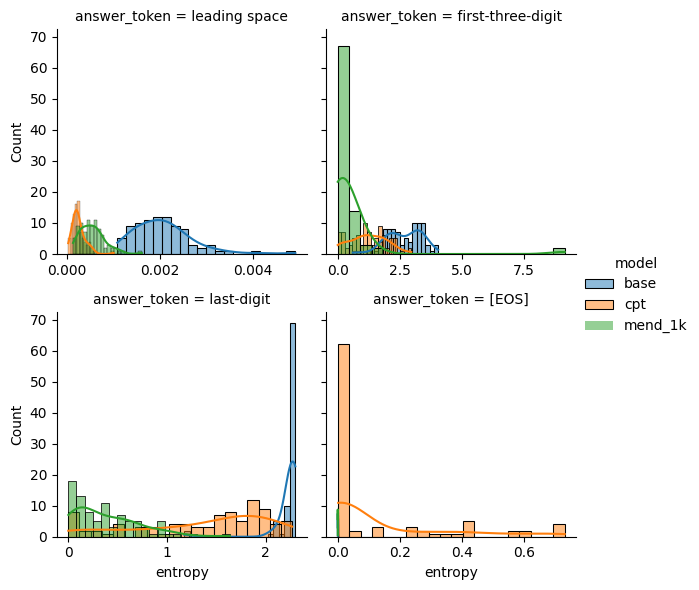

In [223]:
g = sns.FacetGrid(df, col="answer_token", hue="model", col_wrap=2, sharex=False)
g.map(sns.histplot, "entropy", bins=20, kde=True, )
g.add_legend()

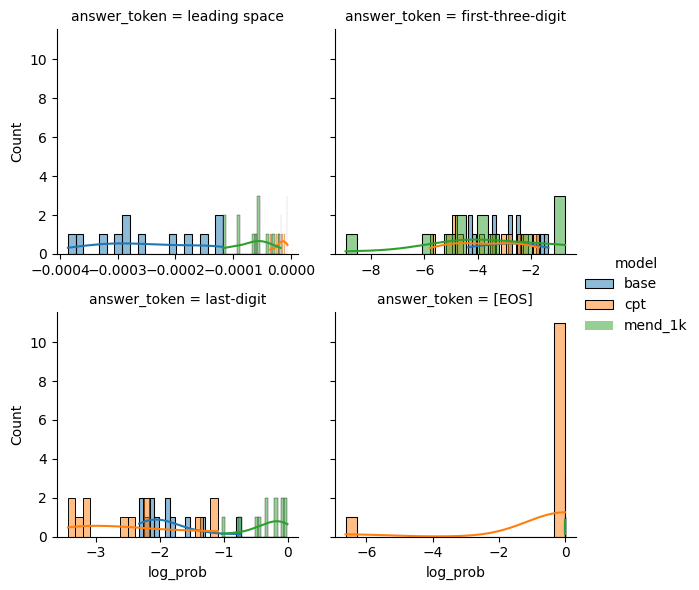

In [241]:
g = sns.FacetGrid(df, col="answer_token", hue="model", col_wrap=2, sharex=False)
g.map(sns.histplot, "log_prob", bins=20, kde=True, )
g.add_legend()

In [242]:


df_content = []

a = defaultdict(list)

for model_name, analysis_results in [
    ("base", carrier_base_analysis_results),
    ("cpt", carrier_cpt_analysis_results),
    ("mend_1k", carrier_mend_1k_analysis_results)
]:
    for analysis_result in analysis_results:
        answer_labels = np.array(analysis_result["answer_labels"])
        answer_logits = np.array(analysis_result["answer_logits"])
        # left_shift_answer_logits = answer_logits[:, :]
        answer_predictions = answer_logits.argmax(axis=-1)
        answer_log_prob = log_softmax(answer_logits, axis=-1)
        a[model_name].append(np.mean(answer_predictions == answer_labels))
        total_log_prob = 0
        for l_i, label in enumerate(answer_labels):
            
        # answer_labels_no_space_no_eos = answer_labels[1:-1]
        # answer_logits_no_space_no_eos = answer_logits[1:-1]
        
            log_prob = answer_log_prob[l_i, label]
            assert np.isclose(np.exp(answer_log_prob[l_i]).sum(), 1)
            answer_entropy = entropy(np.exp(answer_log_prob[l_i]))
            # total_log_prob += log_prob
        
        # mean_log_prob = log_prob / len(answer_labels)
            if l_i == 0:
                answer_token_position = "leading space"
            elif l_i == len(answer_labels) - 1:
                answer_token_position = "[EOS]"
            elif l_i == 1:
                answer_token_position = "first-three-digit"
            else:
                answer_token_position = "last-digit"
            df_content.append({
                "log_prob": log_prob,
                "entropy": answer_entropy,
                "answer_token": answer_token_position,
                # "mean_log_prob": mean_log_prob,
                "model": model_name,
            })
df = pd.DataFrame(df_content)
    

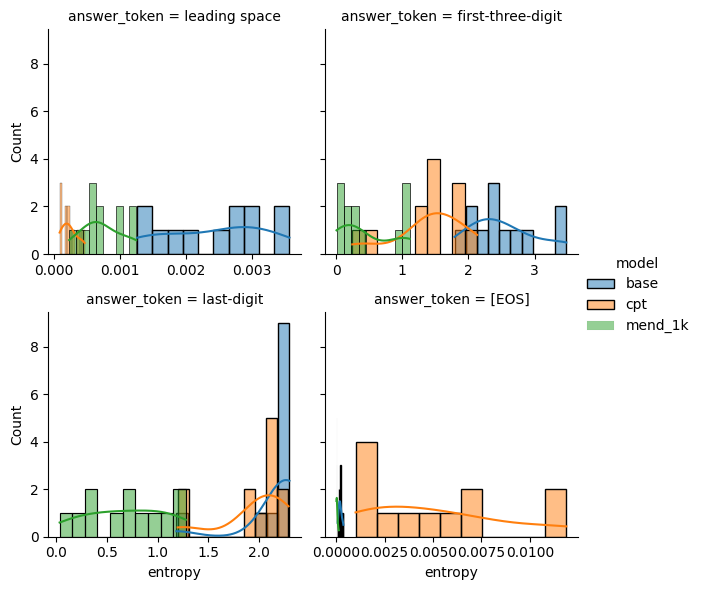

In [245]:
g = sns.FacetGrid(df, col="answer_token", hue="model", col_wrap=2, sharex=False)
g.map(sns.histplot, "entropy", bins=10, kde=True, )
g.add_legend()

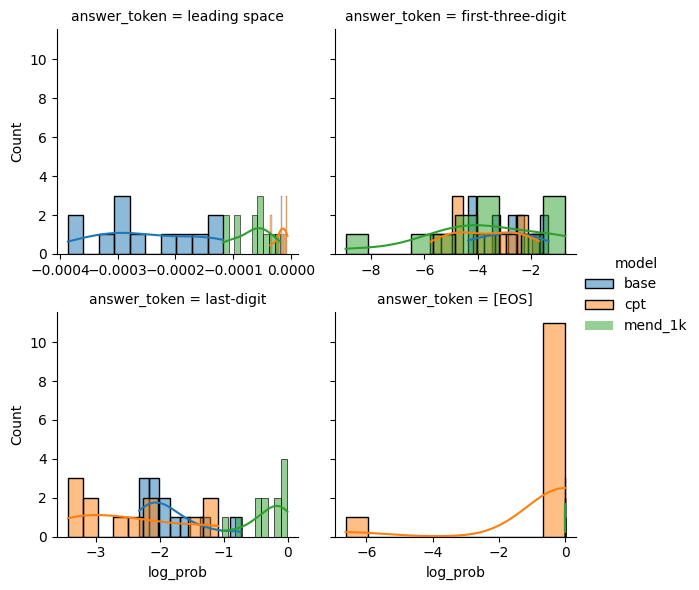

In [246]:
g = sns.FacetGrid(df, col="answer_token", hue="model", col_wrap=2, sharex=False)
g.map(sns.histplot, "log_prob", bins=10, kde=True, )
g.add_legend()

# MEND result on n and n+1 question

In [ ]:
all_mend_1k_n_question_analysis_results = io.load_jsonlines("/data/users/zliu/mend/debug_exp_output/common-date-year-after_1K/bio_syn_analysis/mend_eval_loss=clm_input=question_n=100_prompt=no_wo-icl_n-question_edit-model-infos.jsonl")

assert all(d["answer_labels"][0] == 220 for d in all_mend_1k_n_question_analysis_results)
assert all(d["answer_labels"][-1] == 128001 for d in all_mend_1k_n_question_analysis_results)
assert all([len(x["answer_labels"][1:-1]) == 2 for x in all_mend_1k_n_question_analysis_results])

filtered_mend_1k_n_question_analysis_results = [x for x in all_mend_1k_n_question_analysis_results if not x["answer"].endswith("0")]
carrier_mend_1k_n_question_analysis_results = [x for x in all_mend_1k_n_question_analysis_results if x["answer"].endswith("0")]

In [10]:
df_content = []

a = defaultdict(list)

for model_name, analysis_results in [
    ("n+1 question", filtered_mend_1k_analysis_results),
    ("n question", filtered_mend_1k_n_question_analysis_results)
]:
    for analysis_result in analysis_results:
        answer_labels = np.array(analysis_result["answer_labels"])
        answer_logits = np.array(analysis_result["answer_logits"])
        # left_shift_answer_logits = answer_logits[:, :]
        answer_predictions = answer_logits.argmax(axis=-1)
        answer_log_prob = log_softmax(answer_logits, axis=-1)
        a[model_name].append(np.mean(answer_predictions == answer_labels))
        total_log_prob = 0
        for l_i, label in enumerate(answer_labels):
            
        # answer_labels_no_space_no_eos = answer_labels[1:-1]
        # answer_logits_no_space_no_eos = answer_logits[1:-1]
        
            log_prob = answer_log_prob[l_i, label]
            assert np.isclose(np.exp(answer_log_prob[l_i]).sum(), 1)
            answer_entropy = entropy(np.exp(answer_log_prob[l_i]))
            # total_log_prob += log_prob
        
        # mean_log_prob = log_prob / len(answer_labels)
            if l_i == 0:
                answer_token_position = "leading space"
            elif l_i == len(answer_labels) - 1:
                answer_token_position = "[EOS]"
            elif l_i == 1:
                answer_token_position = "first-three-digit"
            else:
                answer_token_position = "last-digit"
            df_content.append({
                "log_prob": log_prob,
                "entropy": answer_entropy,
                "answer_token": answer_token_position,
                # "mean_log_prob": mean_log_prob,
                "eval_question": model_name,
            })
df = pd.DataFrame(df_content)
    

Text(0.5, 0.98, 'MEND_1K')

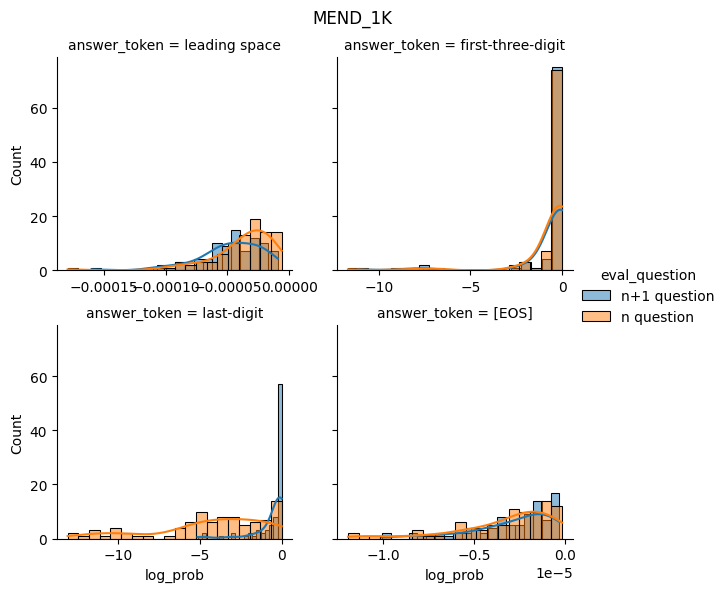

In [16]:
g = sns.FacetGrid(df, col="answer_token", hue="eval_question", col_wrap=2, sharex=False)
g.map(sns.histplot, "log_prob", bins=20, kde=True, )
g.add_legend()
plt.subplots_adjust(top=0.9)
plt.suptitle("MEND_1K")


In [21]:
df_content = []

a = defaultdict(list)

for model_name, analysis_results in [
    ("n+1 question", carrier_mend_1k_analysis_results),
    ("n question", carrier_mend_1k_n_question_analysis_results)
]:
    for analysis_result in analysis_results:
        answer_labels = np.array(analysis_result["answer_labels"])
        answer_logits = np.array(analysis_result["answer_logits"])
        # left_shift_answer_logits = answer_logits[:, :]
        answer_predictions = answer_logits.argmax(axis=-1)
        answer_log_prob = log_softmax(answer_logits, axis=-1)
        a[model_name].append(np.mean(answer_predictions == answer_labels))
        total_log_prob = 0
        for l_i, label in enumerate(answer_labels):
            
        # answer_labels_no_space_no_eos = answer_labels[1:-1]
        # answer_logits_no_space_no_eos = answer_logits[1:-1]
        
            log_prob = answer_log_prob[l_i, label]
            assert np.isclose(np.exp(answer_log_prob[l_i]).sum(), 1)
            answer_entropy = entropy(np.exp(answer_log_prob[l_i]))
            # total_log_prob += log_prob
        
        # mean_log_prob = log_prob / len(answer_labels)
            if l_i == 0:
                answer_token_position = "leading space"
            elif l_i == len(answer_labels) - 1:
                answer_token_position = "[EOS]"
            elif l_i == 1:
                answer_token_position = "first-three-digit"
            else:
                answer_token_position = "last-digit"
            df_content.append({
                "log_prob": log_prob,
                "entropy": answer_entropy,
                "answer_token": answer_token_position,
                # "mean_log_prob": mean_log_prob,
                "eval_question": model_name,
            })
df = pd.DataFrame(df_content)
    

In [28]:
len(carrier_mend_1k_n_question_analysis_results)

10

In [26]:
df

,log_prob,entropy,answer_token,eval_question
0,-3.908863e-05,0.000464,leading space,n+1 question
1,-4.534022e+00,0.312403,first-three-digit,n+1 question
2,-1.029416e+00,0.980118,last-digit,n+1 question
3,-5.599893e-06,0.000074,[EOS],n+1 question
4,-6.128981e-05,0.000690,leading space,n+1 question
...,...,...,...,...
83,-5.276230e-07,0.000009,[EOS],n question
84,-3.925543e-05,0.000470,leading space,n question
85,-1.789215e-03,0.014303,first-three-digit,n question
86,-2.511895e+00,0.397513,last-digit,n question


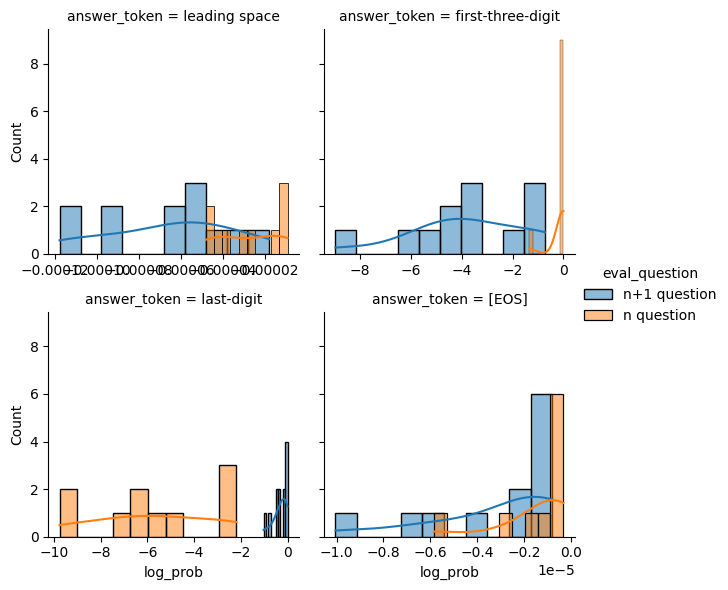

In [18]:
g = sns.FacetGrid(df, col="answer_token", hue="eval_question", col_wrap=2, sharex=False)
g.map(sns.histplot, "log_prob", bins=10, kde=True, )
g.add_legend()